In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import geopandas as gpd
import math 
import collections

### Afegim el fitxer shapefile

In [2]:
db1=gpd.read_file('bseccenv10sh1f1_20210101_0.shp')

### Seleccionem els municipis que ens interessen

In [3]:
df2=db1.loc[db1['MUNICIPI'].isin(['080193', '081017'])]

### Afegim el fixer amb dades socioeconòmiques

In [4]:
renda=pd.read_excel('dades.xlsx')

### Creem i convertim MUNDISSEC en un int64

In [8]:
df2['MUNDISSEC']=pd.to_numeric(df2['MUNDISSEC'])

### Agrupem el df2 (polígons) amb la renda (dades de la renda)

In [9]:
df3=df2.merge(renda, on='MUNDISSEC', how='right')

### Afegim el fitxer amb les adreces

In [10]:
carrers=pd.read_csv('TAULA_DIRELE_SEC_CENS.csv')

### Canviem el nom de TORRENT DE L'OLLA I GV CARLES III ja que el programa no els llegia correctament

In [11]:
carrers['NOM_CARRER']=carrers['NOM_CARRER'].replace(["G.V. Carles III"],['GV Carles 3'])
carrers['NOM_CARRER']=carrers['NOM_CARRER'].replace(["Torrent de l'Olla"],['Torrent Olla'])

### Eliminem columnes innecessàries

In [12]:
carrers2=carrers.drop(columns=['PRIMER_NUM', 'ULTIM_NUM', 'TIPUSNUM', 'AEB', 'SECC_EST'])

### Creem MUNDISSEC que ens permetrà relacionar els carrers amb els polígons.

In [13]:
carrers2['Seccio_censal']=carrers2['DISTRICTE']*1000+carrers2['SECC_CENS']

In [14]:
carrers2['Secciocensal']= carrers2['Seccio_censal'].astype(str).str.zfill(5) 

In [15]:
carrers2['Codimunicipi']='80193'

In [16]:
carrers2['MUNDISSEC']=carrers2['Codimunicipi'].map(str)+carrers2['Secciocensal'].map(str)

In [17]:
carrers2['MUNDISSEC'] = carrers2['MUNDISSEC'].fillna(0).astype(np.int64)

### Afegim les seccions que la pròpia base de dades no tenia

In [20]:
afegit=pd.read_excel('afegit.xlsx')
frames = [carrers2, afegit]
carrers2 = pd.concat(frames)

### Ara sí, afegim el fitxer amb els carrers que nosaltres hem seleccionat.

In [21]:
carrers_selecc=pd.read_excel('carrers_def.xlsx')

### Els agrupem amb el fitxer de carrers de l'ajuntament.

In [22]:
carrersde=carrers2.merge(carrers_selecc,on='NOM_CARRER', how='right')

In [23]:
carrersde

,CARRER,NOM_CARRER,DISTRICTE,SECC_CENS,BARRI,DPOSTAL,Seccio_censal,Secciocensal,Codimunicipi,MUNDISSEC,Nom_Via,TIPUS,DIRECCIÓ,KM
0,177101.0,Via Laietana,1.0,26.0,2.0,8003.0,1026.0,01026,80193,8019301026,VIA LAIETANA,Via,V,1.130
1,177101.0,Via Laietana,1.0,25.0,2.0,8003.0,1025.0,01025,80193,8019301025,VIA LAIETANA,Via,V,1.130
2,177101.0,Via Laietana,1.0,23.0,2.0,8003.0,1023.0,01023,80193,8019301023,VIA LAIETANA,Via,V,1.130
3,177101.0,Via Laietana,1.0,46.0,4.0,8003.0,1046.0,01046,80193,8019301046,VIA LAIETANA,Via,V,1.130
4,177101.0,Via Laietana,1.0,47.0,4.0,8003.0,1047.0,01047,80193,8019301047,VIA LAIETANA,Via,V,1.130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2676,97807.0,Dante Alighieri,7.0,119.0,43.0,8032.0,7119.0,07119,80193,8019307119,DANTE ALIGHIERI,Carrer,T,0.976
2677,97807.0,Dante Alighieri,7.0,71.0,37.0,8032.0,7071.0,07071,80193,8019307071,DANTE ALIGHIERI,Carrer,T,0.976
2678,97807.0,Dante Alighieri,7.0,72.0,37.0,8032.0,7072.0,07072,80193,8019307072,DANTE ALIGHIERI,Carrer,T,0.976
2679,97807.0,Dante Alighieri,7.0,73.0,37.0,8032.0,7073.0,07073,80193,8019307073,DANTE ALIGHIERI,Carrer,T,0.976


### Quan ajuntem a vegades passa que algunes dades passen a ser floats (amb decimals), cal corregir-ho i posar int.

In [24]:
carrersde['MUNDISSEC']=carrersde['MUNDISSEC'].fillna(0).astype(np.int64)

### Ara agrupem les dades amb la selecció de carrers

In [26]:
total=df3.merge(carrersde,on='MUNDISSEC', how='right')

### Calculem les correlacions PER CADA CARRER, ÉS A DIR AGRUPEM LES DADES PER CARRER (UN COP ELIMINADES LES SECCIONS CENSALS DUPLICADES) I CALCULEM LA MEAN()

In [27]:
correlacions1=total.drop_duplicates(subset=['MUNDISSEC', 'NOM_CARRER'], keep="last")
correlacions2=pd.DataFrame(correlacions1.groupby(['NOM_CARRER']).mean()).reset_index()

### Eliminem les columnes que no serveixen a efectes de correlació (és a dir, EL CODI DE LA SECCIÓ...)

In [28]:
correlacions3=correlacions2.drop(columns=['MUNDISSEC', 'KM','Seccio_censal','BARRI','SECC_CENS', 'DISTRICTE_y', 'DPOSTAL', 'CARRER'])

### Creem el gràfic de les correlacions amb la renda.

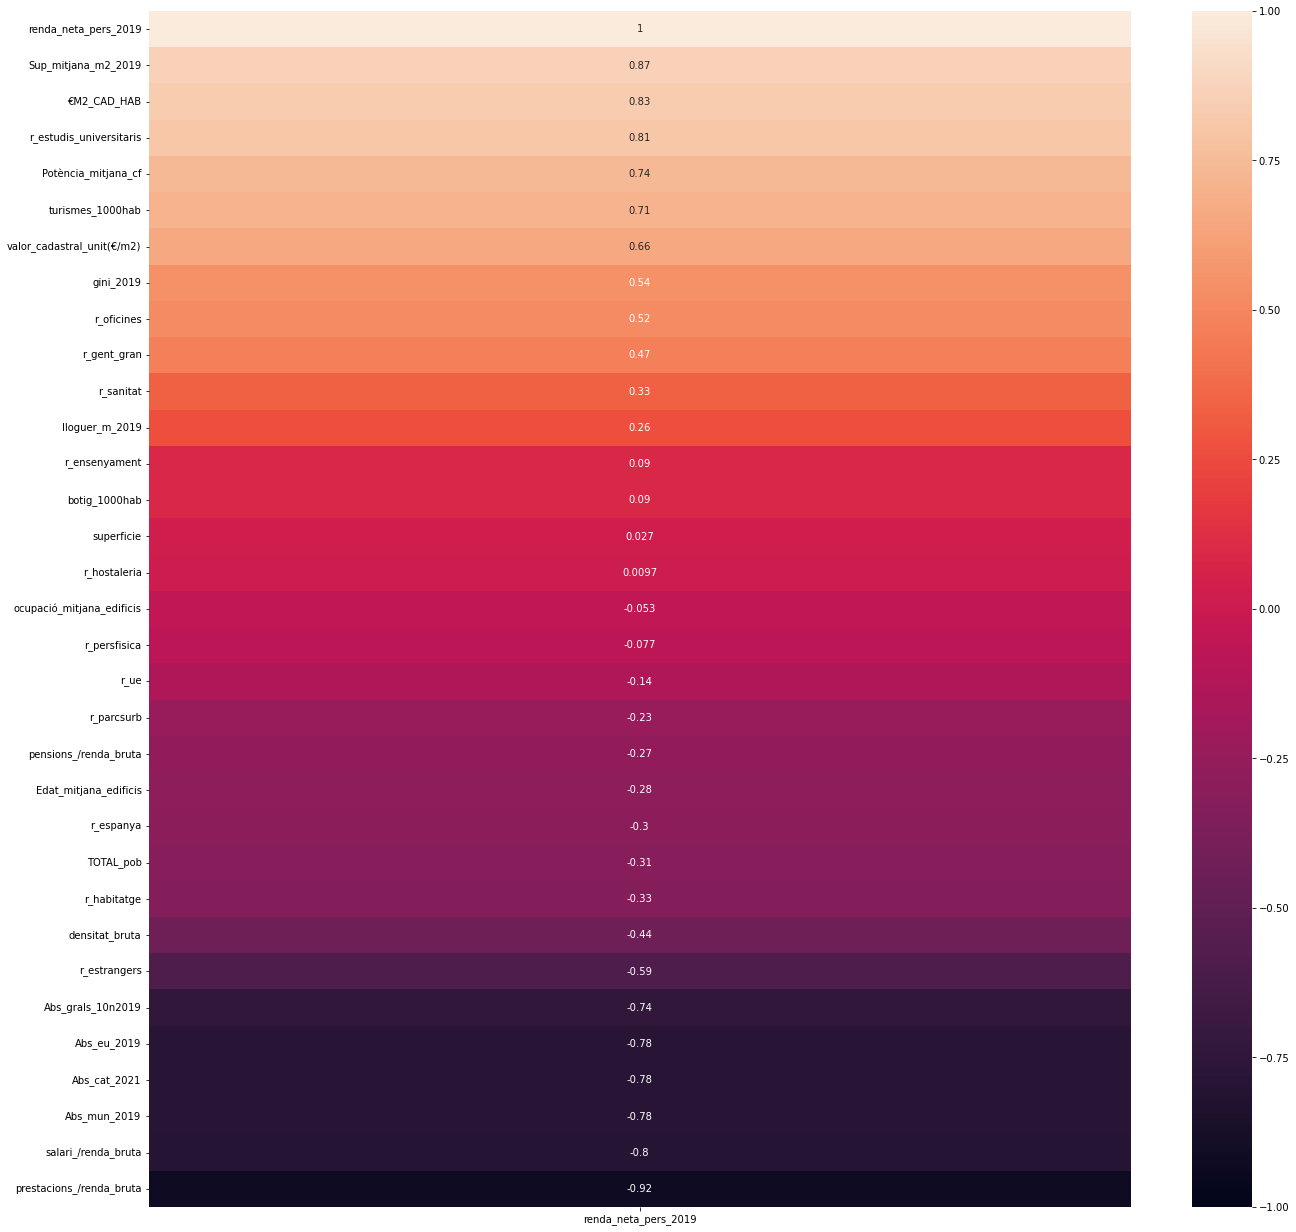

In [29]:
plt.figure(figsize=(22, 22))
heatmap = sns.heatmap(correlacions3.corr()[['renda_neta_pers_2019']].sort_values(by='renda_neta_pers_2019', ascending=False), vmin=-1, vmax=1, annot=True)

In [30]:
corr_selec = correlacions3[['Sup_mitjana_m2_2019', 'valor_cadastral_unit(€/m2)', 'r_gent_gran', 'r_estudis_universitaris', 'renda_neta_pers_2019','turismes_1000hab', 'r_sanitat', 'lloguer_m_2019']]

### Exemple de regressió de la renda amb la superfície mitjana i el valor cadastral.

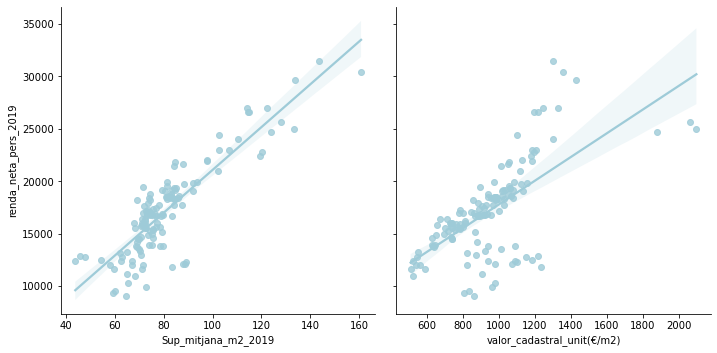

In [31]:
pp = sns.PairGrid(data=corr_selec,y_vars=['renda_neta_pers_2019'],x_vars=['Sup_mitjana_m2_2019', 'valor_cadastral_unit(€/m2)'],height=5)
pp.map(sns.regplot, color="#9ECBD8")
##pp.savefig("reg.jpg", dpi=600)

#gg = sns.PairGrid(data=corr_selec,y_vars=['renda_neta_pers_2019'],x_vars=['r_estudis_universitaris','turismes_1000hab', 'r_sanitat', 'lloguer_m_2019'],height=5)
#gg.map(sns.regplot, color=".3")

### Abans de tot cal eliminar els duplicats de MUNDISSEC segons el nom de carrer. És molt important a l'hora de no repetir observacions.

In [32]:
total2=total.drop_duplicates(subset=['MUNDISSEC', 'NOM_CARRER'], keep="last")

### Li diem que ens faci segons el nom del carrer una descripció (mitjana, std...) per la variable renda.

In [76]:
a=total2.groupby(['NOM_CARRER'])['renda_neta_pers_2019'].describe()

In [77]:
a

,count,mean,std,min,25%,50%,75%,max
NOM_CARRER,,,,,,,,
Alí Bei,7.0,17756.714286,2209.929389,14662.0,16464.50,17740.0,19066.50,20833.0
Ample,4.0,12141.250000,1173.601970,11198.0,11248.25,11838.0,12731.00,13691.0
Amílcar,9.0,15811.222222,1749.668167,13903.0,15297.00,15684.0,15856.00,20040.0
Aragó,45.0,18454.177778,3266.004817,13351.0,16354.00,17818.0,19534.00,29083.0
Aribau,16.0,23015.875000,3222.102396,19148.0,20804.25,22419.5,25200.50,29432.0
...,...,...,...,...,...,...,...,...
Via Favència,21.0,12019.142857,2077.213766,8944.0,9959.00,12078.0,13205.00,16660.0
Via Júlia,9.0,11666.222222,571.932203,10500.0,11346.00,11786.0,12083.00,12393.0
Via Laietana,8.0,13865.250000,1699.821314,12513.0,12699.25,13509.5,14001.25,17714.0


### Creem el coeficient de variació de la renda per cada carrer per tal de comparar la desviació estàndard entre els carrers

In [78]:
a['coef_var']=a['std']/a['mean']*100

In [79]:
coef_var=pd.DataFrame(a['coef_var'])
coef_var

,coef_var
NOM_CARRER,
Alí Bei,12.445599
Ample,9.666237
Amílcar,11.065989
Aragó,17.697916
Aribau,13.999478
...,...
Via Favència,17.282545
Via Júlia,4.902463
Via Laietana,12.259579


### Ara podem veure els x carrers amb un coeficient de variació més elevat.

In [80]:
coef_var.nlargest(12, "coef_var")

,coef_var
NOM_CARRER,
Josep Pla,29.094204
Sant Pere Més Alt,25.346836
Av Diagonal,24.331681
Tarragona,24.242831
Rambla,22.593004
Tànger,21.833464
Numància,21.795730
GV Corts Catalanes,21.277988
Selva de Mar,20.576412


### I també els més baixos

In [37]:
coef_var.nsmallest(12, "coef_var")

,coef_var
NOM_CARRER,
Art,2.083894
Sant Vicenç,3.667752
Torrent Olla,4.194904
Pg Bonanova,4.226078
Nàpols,4.677172
Via Júlia,4.902463
Berlín,4.930746
Fastenrath,5.043124
Manso,5.325629


### Afegim coef_var al df (ja que fins ara el coeficient de variació estava en un df diferent)

In [66]:
total3=total.merge(coef_var, on='NOM_CARRER', how='right')

### Podem calcular la mitjana de coeficient de variació per a tots els carrers seleccionats.

In [68]:
TOTAL3=total3.drop_duplicates(subset=['MUNDISSEC', 'NOM_CARRER'], keep='first')

In [69]:
TOTAL3['coef_var'].mean()

13.41994550833623

## Podem fer la mateixa regressió segons la DIRECCIÓ del carrer

### Mitjana de renda per direcció tenint en compte els carrers.

In [70]:
total4=pd.DataFrame(TOTAL3.groupby(['NOM_CARRER'])['renda_neta_pers_2019'].describe()).reset_index()

In [71]:
total4

,NOM_CARRER,count,mean,std,min,25%,50%,75%,max
0,Alí Bei,7.0,17756.714286,2209.929389,14662.0,16464.50,17740.0,19066.50,20833.0
1,Ample,4.0,12141.250000,1173.601970,11198.0,11248.25,11838.0,12731.00,13691.0
2,Amílcar,9.0,15811.222222,1749.668167,13903.0,15297.00,15684.0,15856.00,20040.0
3,Aragó,45.0,18454.177778,3266.004817,13351.0,16354.00,17818.0,19534.00,29083.0
4,Aribau,16.0,23015.875000,3222.102396,19148.0,20804.25,22419.5,25200.50,29432.0
...,...,...,...,...,...,...,...,...,...
130,Via Favència,21.0,12019.142857,2077.213766,8944.0,9959.00,12078.0,13205.00,16660.0
131,Via Júlia,9.0,11666.222222,571.932203,10500.0,11346.00,11786.0,12083.00,12393.0
132,Via Laietana,8.0,13865.250000,1699.821314,12513.0,12699.25,13509.5,14001.25,17714.0
133,Vila i Vilà,5.0,12942.600000,1670.313533,11377.0,11922.00,11936.0,14423.00,15055.0


In [72]:
total5=total4.merge(carrers_selecc, on='NOM_CARRER', how='right')

In [73]:
b=total5[['NOM_CARRER', 'DIRECCIÓ']]

### Mitjana de renda per direcció (carrer sencer)

In [74]:
total5.groupby(['DIRECCIÓ'])['mean'].describe()

,count,mean,std,min,25%,50%,75%,max
DIRECCIÓ,,,,,,,,
H,46.0,16800.855345,3816.462827,9087.400000,14126.837500,16969.600806,18963.014881,31501.285714
T,33.0,16430.359357,4382.201079,10988.818182,13350.150000,15608.562500,16947.000000,26966.909091
V,56.0,17969.484624,4657.215940,9362.666667,15196.605903,18111.744949,19891.500774,30404.083333


### Creem general que és la mitjana de totes les variables per carrer

In [49]:
general=pd.DataFrame(TOTAL3.groupby('NOM_CARRER').mean().reset_index())

### Correlació de coef_var i KM

In [50]:
general2=general.merge(a, on='NOM_CARRER', how='right')

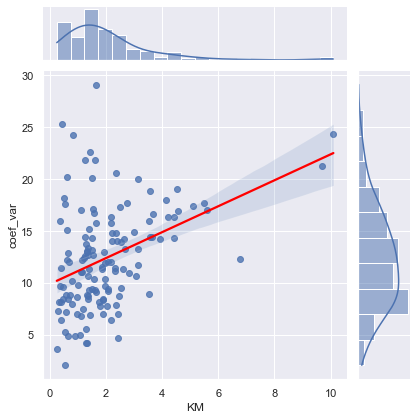

In [51]:
sns.set_theme(color_codes=True)
g=sns.jointplot(data=general2, y='coef_var', x= 'KM', kind="reg")
regline = g.ax_joint.get_lines()[0]
regline.set_color('red')
regline.set_zorder(5)

### Segons la direcció

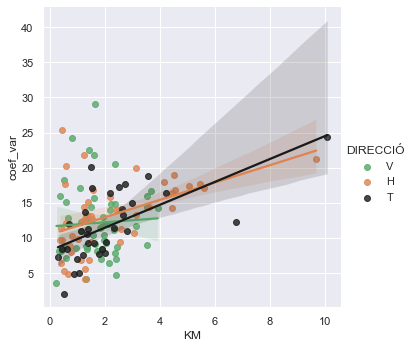

In [52]:
sns.set_theme(color_codes=True)
bb=sns.lmplot(data=general2, y='coef_var', x= 'KM', hue="DIRECCIÓ", palette=["g", "C1", "k"])

### Aquí podem veure la correlació (general i per direcció)

In [53]:
corr=general2['coef_var'].corr(general2['KM'])
print(corr)
general2.groupby('DIRECCIÓ')[['coef_var','KM']].corr().unstack().iloc[:,1]
#total3.groupby('DIRECCIÓ')[['KM']].describe()

0.39514089263018687


DIRECCIÓ
H    0.476884
T    0.633695
V    0.052495
Name: (coef_var, KM), dtype: float64

### Creem l'índex d'habitabilitat.

In [54]:
general2['indexre']=(np.log10(general2['renda_neta_pers_2019'])-np.log10(100))/(np.log10(60000)-np.log10(100))

In [55]:
general2['indexbo']=np.log(general2['botig_1000hab'])/np.log(4.5*np.percentile(general2['botig_1000hab'], 75))

In [56]:
general2['indexsu']=np.log(general2['Sup_mitjana_m2_2019'])/np.log(3*np.percentile(general2['Sup_mitjana_m2_2019'], 75))

In [57]:
general2['indexes']=np.sqrt(general2['r_estudis_universitaris'])

In [58]:
general2['index']=general2[['indexre', 'indexbo', 'indexsu','indexes']].mean(axis=1)

In [60]:
general2['index']

0      0.757979
1      0.740732
2      0.771246
3      0.718666
4      0.849511
         ...   
130    0.624317
131    0.741033
132    0.625443
133    0.793333
134    0.659799
Name: index, Length: 135, dtype: float64